In [1]:
import copy
import os
import time
import operator
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
Alldata = None

In [3]:
data_dir = 'dataset'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def get_dataset(data_dir):
        file_list = sorted(os.listdir(data_dir))
        dataset_file = []
        for file in file_list:
            if file.find("dataset") != -1:
                dataset_file.append(os.path.join(data_dir, file))
        return dataset_file

In [5]:
 def probability_distribution(data, name, bins=50):
        figure, (ax0, ax1) = plt.subplots(2, 1)
        ax0.hist(data, bins, facecolor='blue', edgecolor='black', alpha=0.75, weights=np.ones_like(data) / len(data))
        ax0.set_title(name + ' p_distributation')
        ax1.hist(data, bins, density=True, facecolor='yellowgreen', edgecolor='black', alpha=0.75, cumulative=True)
        ax1.set_title(name + ' sum_distribution')
        plt.show()
        figure.savefig(name + '.png', dpi=600, format='png')

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.activation = nn.ReLU()
        self.linear1 = nn.Sequential(nn.Linear(input_dim, 100), self.activation)
        self.linear2 = nn.Sequential(nn.Linear(100, 100), self.activation)
        self.linear3 = nn.Sequential(nn.Linear(100, 64), self.activation)
        self.linear4 = nn.Sequential(nn.Linear(64, 64), self.activation)
        self.linear5 = nn.Sequential(nn.Linear(64, 64), self.activation)
        self.linear6 = nn.Sequential(nn.Linear(64, 32), self.activation)
        self.linear7 = nn.Sequential(nn.Linear(32, 16), self.activation)
        self.linear8 = nn.Sequential(nn.Linear(16, 1), nn.Softplus())
        self.model = nn.Sequential(self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6,
                                   self.linear7, self.linear8)

    def forward(self, x):
        out = self.model(x)
        return out

In [7]:
class ReDistanceTool():
    def __init__(self, graph_path, graph_name, graph_type):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_split = 0.8

        self.graph_path = graph_path
        self.graph_type = graph_type  # 0: unweighted 1: weighted
        self.graph_name = graph_name
        # use id to save
        self.label_to_id_map = dict()
        self.beacons_start = 0
        # how to concat
        self.train_pairs = set()  # const train pairs
        self.init_beacons_num = 50
        self.iter_beacons_num = 10
        self.max_beacons_num = 100
        self.max_pairs_num = 20
        self.max_relative_error = 1e-2
        self.train_size = 2000
        self.beacons = set([])
        self.graph = None
        self.dis_data = None
        self.dis_value = None
        self.errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        np.random.seed(42)
        self.init_graph()
        self.label_to_id_map = {list(self.graph.nodes())[index]:index for index in range(self.graph.order())}
        global Alldata
        print(type(Alldata))
        time1 = time.time()
        self.distance_dict = dict(nx.all_pairs_shortest_path_length(self.graph)) if not Alldata else Alldata # iterator with dictionary keyed by target and shortest path length as the key value
        Alldata = copy.deepcopy(self.distance_dict)
        time2 = time.time()
        print("compute cost {:2f} s".format(time2 - time1))
        ## to see whether ordered insert
        #         test_num = 3
        #         i = 0
        #         for key, value in self.distance_dict.items():
        #             print(key)
        #             i += 1
        #             j= 0
        #             for key_s, value_s in value.items():
        #                 print(key_s)
        #                 j += 1
        #                 if j >= 3:
        #                     break
        #             if i >= 3:
        #                 break
        #         print((list)self.graph.nodes()[:2])
        ######################## the answer is no ##################

        time1 = time.time()
        self.distance_dict_numpy = self.prepare_distance_numpy()
        time2 = time.time()
        print("construct cost {:2f} s".format(time2 - time1))
        self.init_beacons()
        self.init_train_pairs()
        while(len(self.train_pairs) <= self.train_size//2):
            self.init_beacons()
            self.init_train_pairs()

    def init_graph(self):
        if self.graph_type == 0:
            self.graph = nx.read_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)
        elif self.graph_type == 1:
            self.graph = nx.read_weighted_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)

    def init_beacons(self):
        self.beacons = None
        start = time.time()
        while self.beacons is None or len(self.beacons) < self.init_beacons_num:
            beacon = random.choice(list(range(self.graph.order())))
            if np.where(self.distance_dict_numpy[beacon,:] != np.inf)[0].size > 2*self.train_size  and np.where(self.distance_dict_numpy[:, beacon] != np.inf)[0].size > 2*self.train_size:
                self.beacons = set([beacon]) if self.beacons is None else self.beacons | set([beacon])
        print("finish beacons init in {:4f}".format(time.time() - start))

    def init_train_pairs(self, add_noise = False):
        self.train_pairs.clear()
        nodes_id = list(range(self.graph.order()))
#         for i in range(self.train_size):
#             src_node_id = random.choice(node_id)
#             des_node_id = random.choice(node_id)
#             self.src_set.append(random.choice(node_id))
#             self.des_set.append(random.choice(node_id))
#         temp_src_set = [random.choice(nodes_id) for _ in range(self.train_size)]
#         temp_des_set = [random.choice(nodes_id) for _ in range(self.train_size)]
        for i in range(self.train_size):
            src = random.choice(nodes_id)
            des = random.choice(nodes_id)
            if np.max(self.distance_dict_numpy[src, list(self.beacons)]) != np.inf and np.max(self.distance_dict_numpy[list(self.beacons), des]) != np.inf and self.distance_dict_numpy[src, des] != np.inf:
                self.train_pairs.add((src,des))
#         if self.train_size <= self.graph.order():
#             id_src = np.random.permutation(self.graph.order())[:self.train_size]
#             id_des = np.random.permutation(self.graph.order())[:self.train_size]
#         for id in range(self.train_size):
#             src_id = id_src[id]
#             des_id = id_des[id]
#             if src_id != des_id:
#                 self.src_set.append(src_id)
#                 self.des_set.append(des_id)
        print("get %d valid pairs" % len(self.train_pairs))
        
        
        src_list,des_list = list(zip(*self.train_pairs))
        self.dis_value = self.distance_dict_numpy[src_list, des_list] + np.random.normal(0, 1e-2, (len(self.train_pairs),)) if add_noise else self.distance_dict_numpy[src_list, des_list]
        

    def prepare_distance_numpy(self):
        # for node_src in range(self.graph.order()):
        #     for node_des in range(self.graph.order()):
        #         self.distance_dict_numpy[node_src, node_des] = self.distance_dict[list(self.graph.nodes())[node_src]][list(self.graph.nodes())[node_des]]
        ## The loop costs much time, refer to https://stackoverflow.com/questions/54021117/convert-dictionary-to-numpy-array we can change it
        # if the dictionary is inserted with the same order of graph.nodes() which means that array[0,1] represent the distance from g.nodes[0] to g.nodes[1]
        # ans = np.array([list(item.values()) for item in self.distance_dict.values()])
        # if the above dictionary are not satisfied, we can use the operator itemgetter
        distance_dict_temp = {node :{node: np.inf for node in self.graph.nodes()} for node in self.graph.nodes()}
        distance_dict = {node : (distance_dict_temp[node].update(self.distance_dict[node]),distance_dict_temp[node])[1] for node in self.graph.nodes()}
        getter = operator.itemgetter(*list(self.graph.nodes()))
        ans = np.array([getter(item) for item in getter(distance_dict)])
        return ans

        
    def prepare_train_set(self):
        src_list,des_list = list(zip(*self.train_pairs))
        dis_src = self.distance_dict_numpy[np.ix_(src_list, list(self.beacons))]
        dis_des = self.distance_dict_numpy[np.ix_(list(self.beacons),des_list)].T
        ## plus L and U
        L = np.max(np.abs(dis_src - dis_des), axis = 1).reshape(len(self.train_pairs),1)
        U = np.min(np.abs(dis_src + dis_des), axis = 1).reshape(len(self.train_pairs),1)
        dis_data = np.concatenate((dis_src, dis_des, L, U), axis=1)
        self.dis_data = dis_data

    def obtain_beacons(self, worst_pairs, beacons_num, sampler = 0):
        scores = dict.fromkeys(self.graph, 0.0) # beacons score
        samplers = [0, 1, 2]
        if sampler not in samplers:
            raise Exception("Not supported sampler")
        hyedges = []
        nodes = list(self.graph.nodes())
        for (src_id, des_id) in worst_pairs:
            src = nodes[src_id]
            des = nodes[des_id]
            try:
                paths = nx.all_shortest_paths(self.graph, source=src, target=des)
                paths = [list(path) for path in paths]
            except nx.NetworkXNoPath:
                continue
            if sampler == 0:  ## hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                for node in hyedge:
                    scores[node] += 1
            elif sampler == 1: ## original hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                if len(hyedge) > 0:
                    hyedges.append(hyedge)
            elif sampler == 2:  ## yalg
                hyedge = []
                num_path = 0
                for path in paths:
                    num_path += 1
                    path.remove(src)
                    path.remove(des)
                    hyedge += path
                for node in hyedge:
                    scores[node] += 1 / num_path

        if sampler == 1:
            while len(hyedges) > 1:
                count = {}
                max_degree = 0
                max_node = 0
                for hyedge in hyedges:
                    for node in hyedge:
                        value = count.get(node, 0)
                        count[node] = value + 1
                for node, degree in count.items():
                    if degree >= max_degree:
                        max_degree = degree
                        max_node = node
                scores[max_node] = len(hyedges)
                # remove
                hyedges = [hyedge for hyedge in hyedges if max_node not in hyedge]
                # for hyedge in hyedges:
                #     for node in hyedge:
                #         bc_estimation[node]  += step
        score_array = np.array([scores[nodes[id]] for id in range(self.graph.order())])
        order1 = np.argsort(-score_array)
        return order1.tolist()[:beacons_num]

    def add_beacons(self, target_pairs):
        ## add the most often occured nodes
        src_list, des_list = list(zip(*self.train_pairs))
        new_beacons_id = set(self.obtain_beacons(target_pairs, beacons_num = self.iter_beacons_num, sampler = 0))
        orign_num = len(self.beacons)
#         for beacon in new_beacons_id:
#             if np.max(self.distance_dict_numpy[self.src_set, beacon]) != np.inf and np.max(self.distance_dict_numpy[self.des_set, beacon]) != np.inf:
#                 self.beacons.add(beacon)
        new_beacons = set([beacon for beacon in new_beacons_id if np.max(self.distance_dict_numpy[src_list, beacon]) != np.inf and np.max(self.distance_dict_numpy[des_list, beacon]) != np.inf])
        self.beacons |= new_beacons
        now_num = len(self.beacons)
        print("add {} new beacons".format(now_num - orign_num))
    
    def probability_distribution(self, data, folder, name, bins=50):
        figure, (ax0, ax1) = plt.subplots(2, 1)
        ax0.hist(data, bins, facecolor='blue', edgecolor='black', alpha=0.75, weights=np.ones_like(data) / len(data))
        ax0.set_title(name + ' p_distributation')
        ax1.hist(data, bins, density=True, facecolor='yellowgreen', edgecolor='black', alpha=0.75, cumulative=True)
        ax1.set_title(name + ' sum_distribution')
        plt.show()
        figure.savefig(folder +"/" +name + 'with_LU.png', dpi=600, format='png')
        
        
    def draw(self, history, estimation, y_test):
        errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        name = self.graph_name+ "_"+ str(len(self.beacons))
        figure = plt.figure(name)
        plt.title("{}: loss".format(name))
        train_pl = plt.plot(history['train'][5:], label='train_loss')
        val_pl = plt.plot(history['val'][5:], label='val_loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss/{} with_LU.png".format(name), dpi=600, format='png')
        plt.show()
#         torch.save({
#             'model_weights': net.state_dict(),
#             'history': history
#         }, './models/{}_model.pkl'.format(name))
        estimation = np.round(np.squeeze(estimation))
        error_abs = np.abs(estimation - y_test)
        error_relative = np.abs(estimation - y_test) / y_test
        mask = np.isfinite(error_relative)
        error_relative = error_relative[mask]

        self.probability_distribution(error_relative, "result_data", name + '_relative_error', 100)
        max_error = np.max(error_abs)
        mean_error = np.mean(error_abs)
        max_relative_error = np.max(error_relative)
        mean_relative_error = np.mean(error_relative)
        errors['max_error'].append(max_error)
        errors['mean_error'].append(mean_error)
        errors['max_relative_error'].append(max_relative_error)
        errors['mean_relative_error'].append(mean_relative_error)
        estimation = estimation.tolist()
        result_file = "result_data" + name + "_estimation.csv"
        with open(result_file, 'w+') as f:
            for idx, dist in enumerate(estimation):
                f.writelines(str(dist) + '\t' + str(y_test[idx]) + '\n')

    def train(self, num_epochs=500, batch_size = 64, verbose=True):
        loss_beacons = {"best_train":[], "final_train":[], "final_val":[]}
        beacons_num = []
        epoch_max_loss = 1e-2
        epoch_max_diff_loss = 1e-4

        criterion = nn.MSELoss()

        while(len(self.beacons) <= self.max_beacons_num):
            # prepare data loader
            self.prepare_train_set()
            model =  LinearRegression(self.dis_data.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.to(self.device)
            print('x dataset shape: {}, y shape: {}'.format(self.dis_data.shape, self.dis_value.shape))
            train_num = (int)(len(self.dis_data)*self.train_split)
            train_data = self.dis_data[:train_num]
            train_value = self.dis_value[:train_num]
            val_data = self.dis_data[train_num:]
            val_value = self.dis_value[train_num:]
            train_inputs = torch.from_numpy(train_data).type(torch.float)
            train_targets = torch.from_numpy(train_value).type(torch.float)
            val_inputs = torch.from_numpy(val_data).type(torch.float)
            val_targets = torch.from_numpy(val_value).type(torch.float)
            train_dataset = TensorDataset(train_inputs, train_targets)
            dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
            history = {'train': [], 'val': []}
            since = time.time()
            best_train_loss = np.inf
            best_val_loss = np.inf
            # best_model_wts = copy.deepcopy(model.state_dict())
            epoch_losses = []
            for epoch in range(num_epochs):
#                 print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#                 print('-' * 10)

                # Each epoch has a training and validation phase
                model.train()
                running_loss = 0.0
                num = 0
                # Iterate over data.
                for x, y in dataloader:
                    num += x.size(0)
                    x = x.to(self.device)
                    y = y.to(self.device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        estimation = model(x)
                        estimation = estimation.squeeze()
                        loss = criterion(estimation, y)
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                    # statistics
                    running_loss += loss.item() * x.size(0)
                ## val
                model.eval()
                val_inputs = val_inputs.to(self.device)
                pred_v = model(val_inputs)
                pred_v = pred_v.squeeze()
                pred_s_v = pred_v.cpu().detach().numpy()
                val_targets_s = val_targets.numpy()
                final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
                history["val"].append(final_val_loss)
                epoch_loss = running_loss / num
                history["train"].append(epoch_loss)
#                 print('train Loss: {:.4f}'.format(epoch_loss))
                if epoch_loss <= best_train_loss:
                    best_train_loss = epoch_loss
                epoch_losses.append(epoch_loss)
                # early stopping
                # if len(epoch_losses) >= 4:
                #     np_losses = np.array(epoch_losses[-4:0])
                #     if np.max(np_losses) < epoch_max_loss and np.max(np.diff(np_losses)) < epoch_max_diff_loss:
                #         print("early stopping at epoch {}".format(epoch))
                #         break

                # deep copy the model

#                 print()

            model.eval()
            train_inputs = train_inputs.to(self.device)
            pred = model(train_inputs)
            pred = pred.squeeze()
            pred_s = pred.cpu().detach().numpy()
            train_targets_s = train_targets.numpy()
            final_train_loss = np.mean(np.power(pred_s - train_targets_s, 2))
             
            error_abs = np.abs(np.round(pred_s) - train_targets_s)
            error_relative = error_abs / train_targets_s
            error_relative[np.isinf(error_relative)]=0
            max_pair_s = np.argsort(error_relative)[-self.max_pairs_num:].tolist()
            max_pair_s.reverse()
            
            node_color = ['r'] * self.graph.order()
            for pair in max_pair_s:
                src,des = list(self.train_pairs)[pair]
                print("src:{} des:{}, true:{} est:{}".format( src,des,train_targets_s[pair],pred_s[pair]))
                node_color[src] = 'b'
                node_color[des] = 'b'
            nx.draw_networkx_nodes(self.graph, node_size=5, node_shape="o",edge_size=1, with_labels=True, pos=nx.spring_layout(self.graph), node_color= node_color)
            plt.show()
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            val_inputs = val_inputs.to(self.device)
            pred_v = model(val_inputs)
            pred_v = pred_v.squeeze()
            pred_s_v = pred_v.cpu().detach().numpy()
            val_targets_s = val_targets.numpy()
            final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
            self.draw(history, pred_s_v, val_targets_s)
            print('Best train loss: {:4f} for # {} beacons'.format(best_train_loss, len(self.beacons)))
            print('Final train loss: {:4f} for # {} beacons'.format(final_train_loss, len(self.beacons)))
            print('Final val loss: {:4f} for # {} beacons'.format(final_val_loss, len(self.beacons)))
            loss_beacons["best_train"].append(best_train_loss)
            loss_beacons["final_train"].append(final_train_loss)
            loss_beacons["final_val"].append(final_val_loss)
            beacons_num.append(len(self.beacons))
            start = time.time()
            new_pairs = [list(self.train_pairs)[index] for index in max_pair_s]
            self.add_beacons(zip(new_src, new_des))
            print("add beacons cost %.2f s" % (time.time() - start))
            # load best model weights
            # model.load_state_dict(best_model_wts)
            # return model, history
        figure = plt.figure(self.graph_name)
        plt.title("{}: loss vs beacons_num".format(self.graph_name))
        best_train_pl = plt.plot(beacons_num, loss_beacons['best_train'], label='best_train_loss')
        final_train_pl = plt.plot(beacons_num, loss_beacons['final_train'], label='final_train_loss')
        final_val_pl = plt.plot(beacons_num, loss_beacons['final_val'], label='final_val_loss')
        plt.xlabel('beacons num')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss_with_beacons/{}with_LU.png".format(self.graph_name), dpi=600, format='png')
        plt.show()

In [8]:
# extract the largest commpent of the disconnected graph
class ReDistanceTool_s():
    def __init__(self, graph_path, graph_name, graph_type):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_split = 0.8
        
        self.max_pairs_num = 20
        self.graph_path = graph_path
        self.graph_type = graph_type  # 0: unweighted 1: weighted
        self.graph_name = graph_name
        # use id to save
        self.label_to_id_map = dict()
        self.beacons_start = 0
        # how to concat
        self.train_pairs = set()  # const train pairs
        self.init_beacons_num = 100
        self.iter_beacons_num = 10
        self.max_beacons_num = 200
        self.train_size = 1000
        self.beacons = set([])
        self.graph = None
        self.dis_data = None
        self.dis_value = None
        self.errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        np.random.seed(42)
        self.init_graph()
        self.label_to_id_map = {list(self.graph.nodes())[index]:index for index in range(self.graph.order())}
        global Alldata
        print(type(Alldata))
        time1 = time.time()
        self.distance_dict = dict(nx.all_pairs_shortest_path_length(self.graph)) if not Alldata else Alldata # iterator with dictionary keyed by target and shortest path length as the key value
        Alldata = copy.deepcopy(self.distance_dict)
        time2 = time.time()
        print("compute cost {:2f} s".format(time2 - time1))
        ## to see whether ordered insert
        #         test_num = 3
        #         i = 0
        #         for key, value in self.distance_dict.items():
        #             print(key)
        #             i += 1
        #             j= 0
        #             for key_s, value_s in value.items():
        #                 print(key_s)
        #                 j += 1
        #                 if j >= 3:
        #                     break
        #             if i >= 3:
        #                 break
        #         print((list)self.graph.nodes()[:2])
        ######################## the answer is no ##################

        time1 = time.time()
        self.distance_dict_numpy = self.prepare_distance_numpy()
        time2 = time.time()
        print("construct cost {:2f} s".format(time2 - time1))
        self.init_beacons()
        self.init_train_pairs(add_noise = True)

    def init_graph(self):
        if self.graph_type == 0:
            graph = nx.read_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)
        elif self.graph_type == 1:
            graph = nx.read_weighted_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)
        # extract the max_commpent
        self.graph = graph.subgraph(max(nx.connected_components(graph), key = len)).copy()
        print("graph: {} with node # : {}".format(self.graph_name, self.graph.order()))

    def init_beacons(self, p = None):
        self.beacons = None
        beacons_id = np.random.choice(self.graph.order(), size=self.init_beacons_num, replace=False, p=p)
        self.beacons = set(beacons_id)

    def init_train_pairs(self, p = None, add_noise = False):
        self.train_pairs.clear()
        remain_pairs_num = self.train_size
        while len(self.train_pairs) < self.train_size:
            temp_src = np.random.choice(self.graph.order(), size=remain_pairs_num, replace=True, p=p)
            temp_des = np.random.choice(self.graph.order(), size=remain_pairs_num, replace=True, p=p)
            temp_index = temp_src!= temp_des
            self.train_pairs |= set(zip(temp_src[temp_index].tolist(),temp_des[temp_index].tolist()))
            remain_pairs_num -= sum(temp_index)    
        print("get %d valid pairs" % len(self.train_pairs))
        
        src_list,des_list = list(zip(*self.train_pairs))
        self.dis_value = self.distance_dict_numpy[src_list, des_list] + np.random.normal(0, 1e-2, (len(self.train_pairs),)) if add_noise else self.distance_dict_numpy[src_list, des_list]

    def prepare_distance_numpy(self):
        # for node_src in range(self.graph.order()):
        #     for node_des in range(self.graph.order()):
        #         self.distance_dict_numpy[node_src, node_des] = self.distance_dict[list(self.graph.nodes())[node_src]][list(self.graph.nodes())[node_des]]
        ## The loop costs much time, refer to https://stackoverflow.com/questions/54021117/convert-dictionary-to-numpy-array we can change it
        # if the dictionary is inserted with the same order of graph.nodes() which means that array[0,1] represent the distance from g.nodes[0] to g.nodes[1]
        # ans = np.array([list(item.values()) for item in self.distance_dict.values()])
        # if the above dictionary are not satisfied, we can use the operator itemgetter
        getter = operator.itemgetter(*list(self.graph.nodes()))
        ans = np.array([getter(item) for item in getter(self.distance_dict)])
        return ans

    def prepare_train_set(self):
        src_list,des_list = list(zip(*self.train_pairs))
        dis_src = self.distance_dict_numpy[np.ix_(src_list, list(self.beacons))]
        dis_des = self.distance_dict_numpy[np.ix_(list(self.beacons),des_list)].T
        ## plus L and U
        L = np.max(np.abs(dis_src - dis_des), axis = 1).reshape(len(self.train_pairs),1)
        U = np.min(np.abs(dis_src + dis_des), axis = 1).reshape(len(self.train_pairs),1)
        dis_data = np.concatenate((dis_src, dis_des, L, U), axis=1)
        self.dis_data = dis_data
        
    def obtain_beacons(self, worst_pairs, beacons_num, sampler = 0):
        scores = dict.fromkeys(self.graph, 0.0) # beacons score
        samplers = [0, 1, 2]
        if sampler not in samplers:
            raise Exception("Not supported sampler")
        hyedges = []
        nodes = list(self.graph.nodes())
        for (src_id, des_id) in worst_pairs:
            src = nodes[src_id]
            des = nodes[des_id]
            try:
                paths = nx.all_shortest_paths(self.graph, source=src, target=des)
                paths = [list(path) for path in paths]
            except nx.NetworkXNoPath:
                continue
            if sampler == 0:  ## hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                for node in hyedge:
                    scores[node] += 1
            elif sampler == 1: ## original hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                if len(hyedge) > 0:
                    hyedges.append(hyedge)
            elif sampler == 2:  ## yalg
                hyedge = []
                num_path = 0
                for path in paths:
                    num_path += 1
                    path.remove(src)
                    path.remove(des)
                    hyedge += path
                for node in hyedge:
                    scores[node] += 1 / num_path

        if sampler == 1:
            while len(hyedges) > 1:
                count = {}
                max_degree = 0
                max_node = 0
                for hyedge in hyedges:
                    for node in hyedge:
                        value = count.get(node, 0)
                        count[node] = value + 1
                for node, degree in count.items():
                    if degree >= max_degree:
                        max_degree = degree
                        max_node = node
                scores[max_node] = len(hyedges)
                # remove
                hyedges = [hyedge for hyedge in hyedges if max_node not in hyedge]
                # for hyedge in hyedges:
                #     for node in hyedge:
                #         bc_estimation[node]  += step
        score_array = np.array([scores[nodes[id]] for id in range(self.graph.order())])
        order1 = np.argsort(-score_array)
        return order1.tolist()[:beacons_num]

    def add_beacons(self, target_pairs):
        ## add the most often occured nodes
        new_beacons_id = set(self.obtain_beacons(target_pairs, beacons_num = self.iter_beacons_num, sampler = 0))
        orign_num = len(self.beacons)
#         for beacon in new_beacons_id:
#             if np.max(self.distance_dict_numpy[self.src_set, beacon]) != np.inf and np.max(self.distance_dict_numpy[self.des_set, beacon]) != np.inf:
#                 self.beacons.add(beacon)

        self.beacons |= new_beacons_id
        now_num = len(self.beacons)
        print("add {} new beacons".format(now_num - orign_num))
    
    def probability_distribution(self, data, folder, name, bins=50):
        figure, (ax0, ax1) = plt.subplots(2, 1)
        ax0.hist(data, bins, facecolor='blue', edgecolor='black', alpha=0.75, weights=np.ones_like(data) / len(data))
        ax0.set_title(name + ' p_distributation')
        ax1.hist(data, bins, density=True, facecolor='yellowgreen', edgecolor='black', alpha=0.75, cumulative=True)
        ax1.set_title(name + ' sum_distribution')
        plt.show()
        figure.savefig(folder +"/" +name + 'with_LU.png', dpi=600, format='png')
        
        
    def draw(self, history, estimation, y_test):
        errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        name = self.graph_name+ "_"+ str(len(self.beacons))
        figure = plt.figure(name)
        plt.title("{}: loss".format(name))
        train_pl = plt.plot(history['train'][5:], label='train_loss')
        val_pl = plt.plot(history['val'][5:], label='val_loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss/{} with_LU.png".format(name), dpi=600, format='png')
        plt.show()
#         torch.save({
#             'model_weights': net.state_dict(),
#             'history': history
#         }, './models/{}_model.pkl'.format(name))
        estimation = np.round(np.squeeze(estimation))
        error_abs = np.abs(estimation - y_test)
        error_relative = np.abs(estimation - y_test) / y_test
        mask = np.isfinite(error_relative)
        error_relative = error_relative[mask]

        self.probability_distribution(error_relative, "result_data", name + '_relative_error', 100)
        max_error = np.max(error_abs)
        mean_error = np.mean(error_abs)
        max_relative_error = np.max(error_relative)
        mean_relative_error = np.mean(error_relative)
        errors['max_error'].append(max_error)
        errors['mean_error'].append(mean_error)
        errors['max_relative_error'].append(max_relative_error)
        errors['mean_relative_error'].append(mean_relative_error)
        estimation = estimation.tolist()
        result_file = "result_data" + name + "_estimation.csv"
        with open(result_file, 'w+') as f:
            for idx, dist in enumerate(estimation):
                f.writelines(str(dist) + '\t' + str(y_test[idx]) + '\n')

    def train(self, num_epochs=1000, batch_size = 256, verbose=True):
        loss_beacons = {"best_train":[], "final_train":[], "final_val":[]}
        beacons_num = []
        epoch_max_loss = 1e-2
        epoch_max_diff_loss = 1e-4

        criterion = nn.MSELoss()

        while(len(self.beacons) <= self.max_beacons_num):
            # prepare data loader
            self.prepare_train_set()
            model =  LinearRegression(self.dis_data.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.to(self.device)
            print('x dataset shape: {}, y shape: {}'.format(self.dis_data.shape, self.dis_value.shape))
            train_num = (int)(len(self.dis_data)*self.train_split)
            train_data = self.dis_data[:train_num]
            train_value = self.dis_value[:train_num]
            val_data = self.dis_data[train_num:]
            val_value = self.dis_value[train_num:]
            train_inputs = torch.from_numpy(train_data).type(torch.float)
            train_targets = torch.from_numpy(train_value).type(torch.float)
            val_inputs = torch.from_numpy(val_data).type(torch.float)
            val_targets = torch.from_numpy(val_value).type(torch.float)
            train_dataset = TensorDataset(train_inputs, train_targets)
            dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
            history = {'train': [], 'val': []}
            since = time.time()
            best_train_loss = np.inf
            best_val_loss = np.inf
            # best_model_wts = copy.deepcopy(model.state_dict())
            epoch_losses = []
            for epoch in range(num_epochs):
#                 print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#                 print('-' * 10)

                # Each epoch has a training and validation phase
                model.train()
                running_loss = 0.0
                num = 0
                # Iterate over data.
                for x, y in dataloader:
                    num += x.size(0)
                    x = x.to(self.device)
                    y = y.to(self.device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        estimation = model(x)
                        estimation = estimation.squeeze()
                        loss = criterion(estimation, y)
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                    # statistics
                    running_loss += loss.item() * x.size(0)
                ## val
                model.eval()
                val_inputs = val_inputs.to(self.device)
                pred_v = model(val_inputs)
                pred_v = pred_v.squeeze()
                pred_s_v = pred_v.cpu().detach().numpy()
                val_targets_s = val_targets.numpy()
                final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
                history["val"].append(final_val_loss)
                epoch_loss = running_loss / num
                history["train"].append(epoch_loss)
#                 print('train Loss: {:.4f}'.format(epoch_loss))
                if epoch_loss <= best_train_loss:
                    best_train_loss = epoch_loss
                epoch_losses.append(epoch_loss)
                # early stopping
                # if len(epoch_losses) >= 4:
                #     np_losses = np.array(epoch_losses[-4:0])
                #     if np.max(np_losses) < epoch_max_loss and np.max(np.diff(np_losses)) < epoch_max_diff_loss:
                #         print("early stopping at epoch {}".format(epoch))
                #         break

                # deep copy the model

#                 print()

            model.eval()
            train_inputs = train_inputs.to(self.device)
            pred = model(train_inputs)
            pred = pred.squeeze()
            pred_s = pred.cpu().detach().numpy()
            train_targets_s = train_targets.numpy()
            final_train_loss = np.mean(np.power(pred_s - train_targets_s, 2))
            val_inputs = val_inputs.to(self.device)
            pred_v = model(val_inputs)
            pred_v = pred_v.squeeze()
            pred_s_v = pred_v.cpu().detach().numpy()
            val_targets_s = val_targets.numpy()
            final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
            self.draw(history, pred_s_v, val_targets_s)
            print('Best train loss: {:4f} for # {} beacons'.format(best_train_loss, len(self.beacons)))
            print('Final train loss: {:4f} for # {} beacons'.format(final_train_loss, len(self.beacons)))
            print('Final val loss: {:4f} for # {} beacons'.format(final_val_loss, len(self.beacons)))
            loss_beacons["best_train"].append(best_train_loss)
            loss_beacons["final_train"].append(final_train_loss)
            loss_beacons["final_val"].append(final_val_loss)
            beacons_num.append(len(self.beacons))
#           max_pair_s = np.argsort(-(abs(pred_s - train_targets_s, 2)))[:self.max_pairs].tolist()
 
            error_abs = np.abs(np.round(pred_s) - train_targets_s)
            error_relative = error_abs / train_targets_s
            error_relative[np.isinf(error_relative)]=0
            max_pair_s = np.argsort(error_relative)[-self.max_pairs_num:].tolist()
            max_pair_s.reverse()
            node_color = ['red'] * self.graph.order()
            node_labels = dict.fromkeys(self.graph, "")
            src_list,des_list = list(zip(*self.train_pairs))
            for index, pair in enumerate(max_pair_s):
                src,des = list(self.train_pairs)[pair]
                print("src:{} des:{}, true:{} est:{}".format(src,des,train_targets_s[pair],pred_s[pair]))
                node_color[src] = 'blue'
                node_color[des] = 'blue'
                node_labels[list(self.graph.nodes())[src]] = str(index)
                node_labels[list(self.graph.nodes())[des]] = str(index)
            for beacon in self.beacons:
                node_color[beacon] = "black"
            nx.draw_networkx(self.graph, node_size=5, node_shape="o", width=0.5, edge_color = '#CDB38B',style = "dashdot",
                             with_labels=True, labels = node_labels, pos=nx.kamada_kawai_layout(self.graph, dist= self.distance_dict), node_color= node_color)
            plt.show()
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))

            start = time.time()
            new_pairs = [list(self.train_pairs)[index] for index in max_pair_s]
            self.add_beacons(zip(new_src, new_des))
            print("add beacons cost %.2f s" % (time.time() - start))
            # load best model weights
            # model.load_state_dict(best_model_wts)
            # return model, history
        figure = plt.figure(self.graph_name)
        plt.title("{}: loss vs beacons_num".format(self.graph_name))
        best_train_pl = plt.plot(beacons_num, loss_beacons['best_train'], label='best_train_loss')
        final_train_pl = plt.plot(beacons_num, loss_beacons['final_train'], label='final_train_loss')
        final_val_pl = plt.plot(beacons_num, loss_beacons['final_val'], label='final_val_loss')
        plt.xlabel('beacons num')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss_with_beacons/{}with_LU.png".format(self.graph_name), dpi=600, format='png')
        plt.show()

# Note: how to solve the nodes in the pair is not connected 
* extract the largest component
* add extra steps

begin to train
graph: CA-GrQc with node # : 4158
<class 'NoneType'>
compute cost 73.641164 s
construct cost 2.082934 s
get 1000 valid pairs
prepare cost 76.04 s
x dataset shape: (1000, 202), y shape: (1000,)


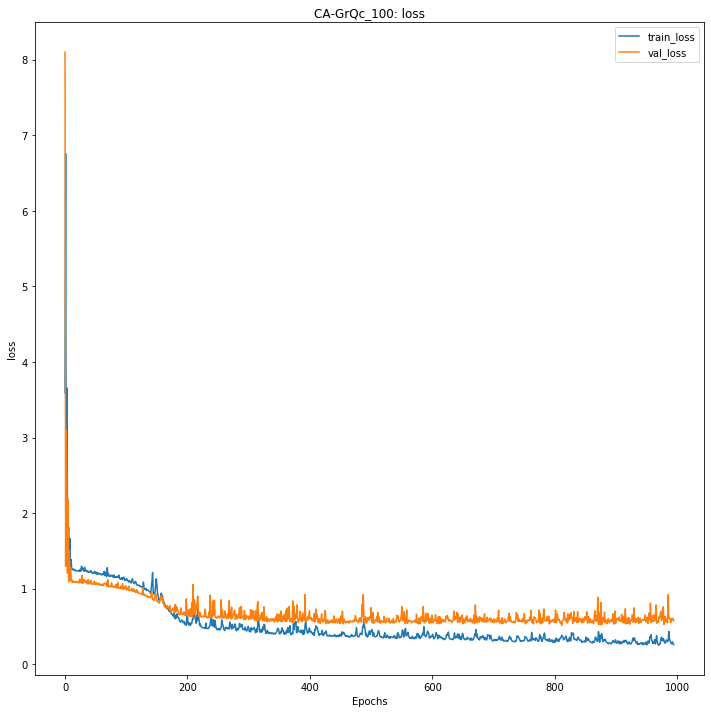

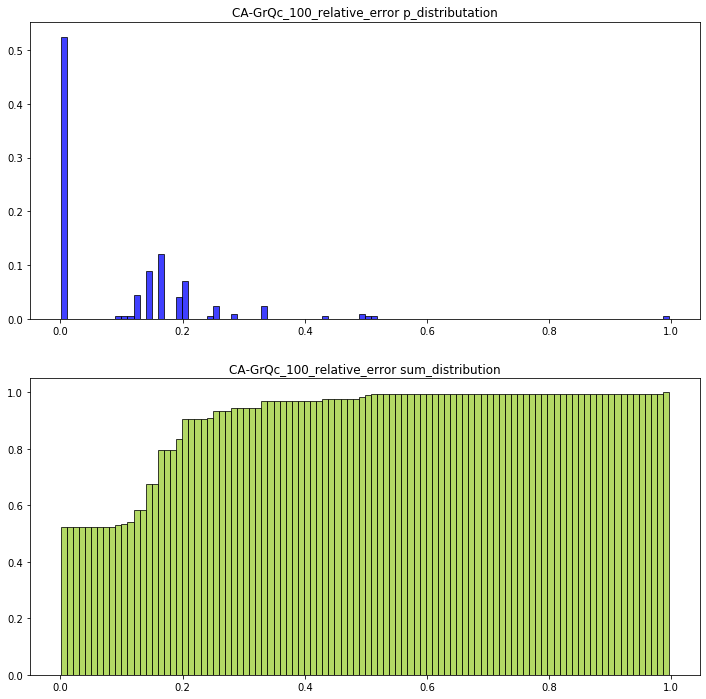

Best train loss: 0.253999 for # 100 beacons
Final train loss: 0.248662 for # 100 beacons
Final val loss: 0.576254 for # 100 beacons
src:1099 des:4125, true:1.9841572046279907 est:3.5692009925842285
src:602 des:1751, true:2.9998207092285156 est:5.266172885894775
src:2799 des:2173, true:3.010075092315674 est:4.519405364990234
src:2230 des:3511, true:3.991757392883301 est:5.558061599731445
src:3308 des:1583, true:4.001145362854004 est:5.532514572143555
src:2463 des:746, true:5.001469135284424 est:6.651451587677002
src:717 des:2665, true:5.004171848297119 est:7.183602333068848
src:1711 des:1079, true:2.983464241027832 est:3.997783660888672
src:1167 des:312, true:2.9862864017486572 est:3.5817606449127197
src:609 des:15, true:2.995579957962036 est:3.500847578048706
src:3516 des:1004, true:2.9980132579803467 est:3.6377580165863037
src:498 des:923, true:3.000007152557373 est:3.6328015327453613
src:2749 des:1481, true:3.0008511543273926 est:3.626737117767334
src:71 des:610, true:3.0009882450103

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize']=(12,12)

graph_path = "dataset/graph/CA-GrQc.txt"
print("begin to train")
start = time.time()
tool_s = ReDistanceTool_s(graph_path = graph_path, graph_name = "CA-GrQc", graph_type = 0)
print("prepare cost %.2f s" % (time.time() - start))
tool_s.train()

In [ ]:

# graph_path = "dataset/graph/CA-AstroPh.txt"
# # node_color = ['r'] * self.graph.order()
# graph = nx.read_edgelist(graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)
# # for pair in max_pair_s:
# #     src = self.src_set[pair]
# #     des = self.des_set[pair]
# #     print("src:{} des:{}, true:{} est:{}".format( self.src_set[pair],self.des_set[pair],train_targets_s[pair],pred_s[pair]))
# #     node_color[src] = 'b'
# #     node_color[des] = 'b'
# nx.draw_networkx_nodes(graph,with_labels=True, pos=nx.spring_layout(graph))
# plt.show()